In [13]:
import copy
import glob
import pickle
import warnings
from datetime import datetime, timedelta
from itertools import product
import joblib
import os
import numpy as np
import xarray as xr
import pandas as pd
import copy
from datetime import datetime, timedelta
from keras.utils import to_categorical
# import visualkeras
# import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
import optuna
from optuna.samplers import TPESampler
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.feature as cf
import cartopy.io.shapereader as shpreader

import matplotlib as mpl
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(42)
import pandas as pd
import shapely.geometry as sgeom
import xarray as xr
from scipy import stats
from scipy.spatial.distance import cdist
from shapely import geometry
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [124]:
folder_performance = 'dics_performance_v2'

# Gather results

In [125]:
dic_full = {}
for name_var in ['IT_SODA', 'OHC100_SODA', 'SD_ERA5', 'STL_full_ERA5', 'SWVL_full_ERA5', 'Z500_ERA5',
                 'MLD_SODA', 'OLR_ERA5', 'SST_SODA', 'SWVL_28cm_ERA5', 'U200_ERA5']:
    dic_full[name_var] = {}
    for week_out in [0,1,2,3,4,5,6,7,8]:
        week_out_str = f'week{week_out}'
        file_performance = f'{folder_performance}/dic_{name_var}_{week_out_str}.npy'
        try:
            dic_performance = np.load(file_performance,allow_pickle=True)[()]
        except: pass
        dic_full[name_var][week_out] = dic_performance

# 1. Plot accuracies

In [126]:
acc_array = []
for name_var in ['IT_SODA', 'OHC100_SODA', 'SD_ERA5', 'STL_full_ERA5', 'SWVL_full_ERA5', 'Z500_ERA5',
                 'MLD_SODA', 'OLR_ERA5', 'SST_SODA', 'SWVL_28cm_ERA5', 'U200_ERA5']:
    acc_array_var = []
    for week_out in [0,1,2,3,4,5,6,7,8]:
        acc_array_var.append(dic_full[name_var][week_out]['acc'])
    acc_array.append(acc_array_var)

In [127]:
acc_array = np.array(acc_array)

In [128]:
acc_persistence = []
name_var = 'Z500_ERA5'
for week_out in [0,1,2,3,4,5,6,7,8]:
    acc_persistence.append(dic_full[name_var][week_out]['acc_persistence'])
acc_persistence = np.array(acc_persistence)

In [129]:
names_var = np.array(['IT_SODA', 'OHC100_SODA', 'SD_ERA5', 'STL_full_ERA5', 'SWVL_full_ERA5', 'Z500_ERA5',
                 'MLD_SODA', 'OLR_ERA5', 'SST_SODA', 'SWVL_28cm_ERA5', 'U200_ERA5'])
weeks_out = np.array([0,1,2,3,4,5,6,7,8])
classes_var = np.array(['O','O','L','L','L','A','O','A','O','L','A'])

In [130]:
df_acc = pd.DataFrame(acc_array.T,index = weeks_out,columns = names_var)

In [131]:
df_acc['Persistence'] = acc_persistence

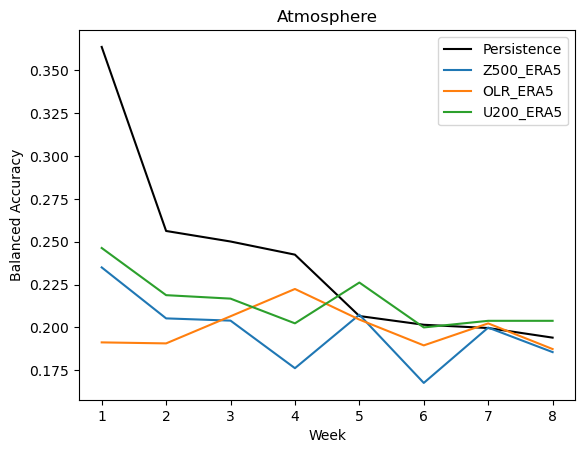

In [132]:
plt.plot(df_acc['Persistence'].loc[1:],label = 'Persistence',color='k')
for name in names_var[classes_var == 'A']:
    plt.plot(df_acc[name].loc[1:],label = name)
plt.title('Atmosphere')
plt.xlabel('Week')
plt.ylabel('Balanced Accuracy')
plt.legend()

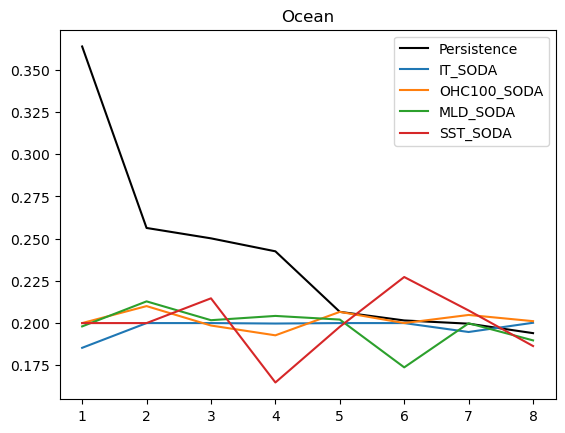

In [133]:
plt.plot(df_acc['Persistence'].loc[1:],label = 'Persistence',color='k')
for name in names_var[classes_var == 'O']:
    plt.plot(df_acc[name].loc[1:],label = name)
plt.title('Ocean')
plt.legend()

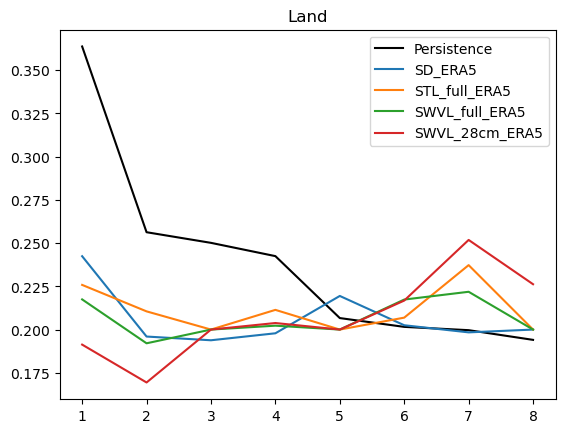

In [134]:
plt.plot(df_acc['Persistence'].loc[1:],label = 'Persistence',color='k')
for name in names_var[classes_var == 'L']:
    plt.plot(df_acc[name].loc[1:],label = name)
plt.title('Land')
plt.legend()

# Seasonal variation of performance

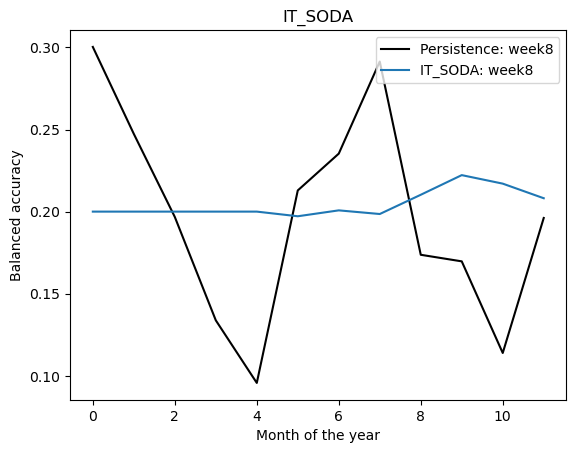

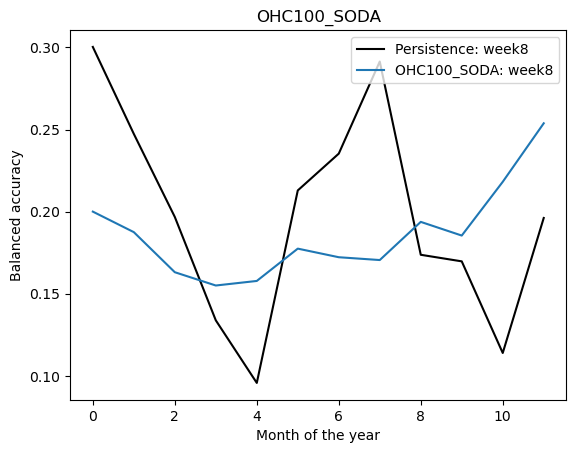

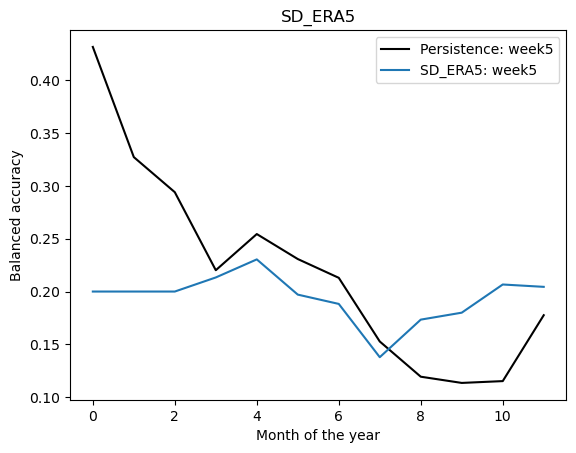

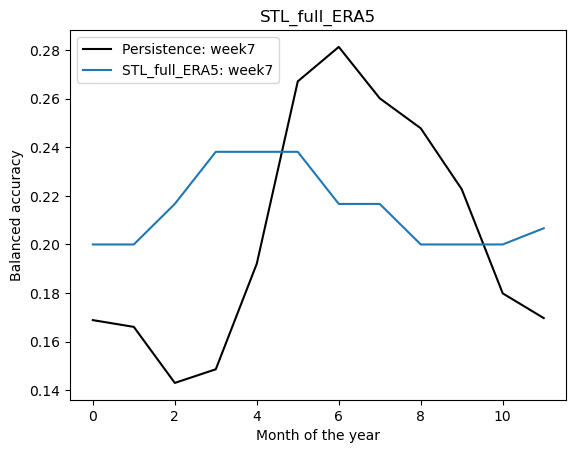

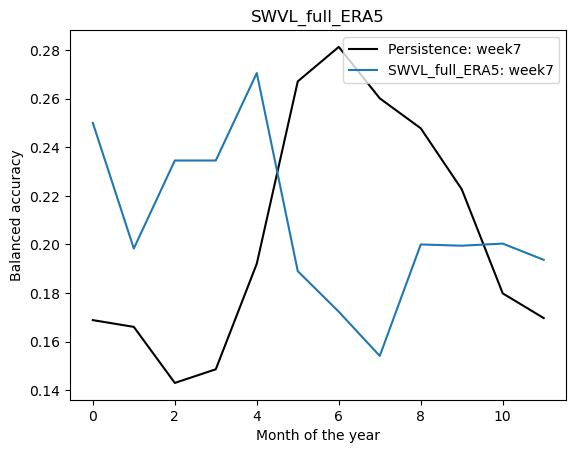

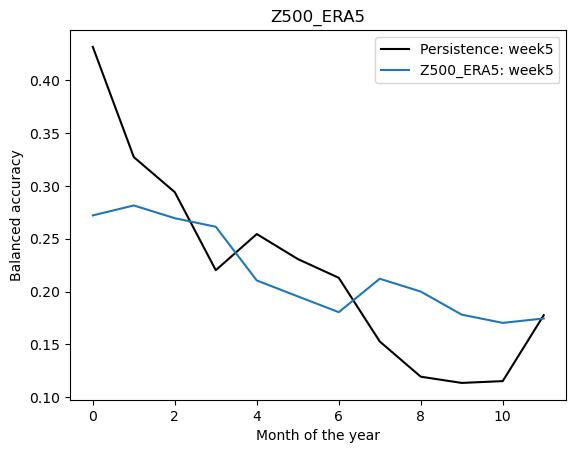

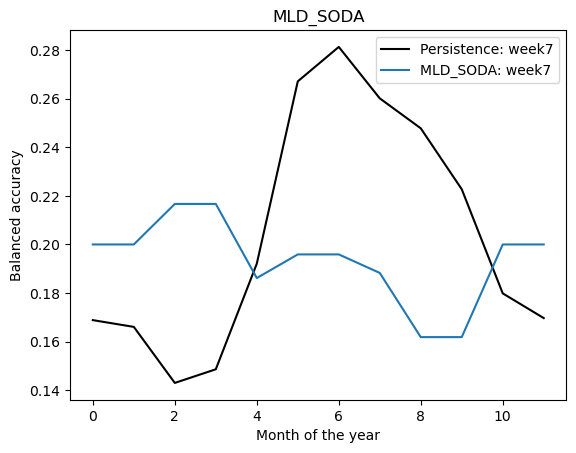

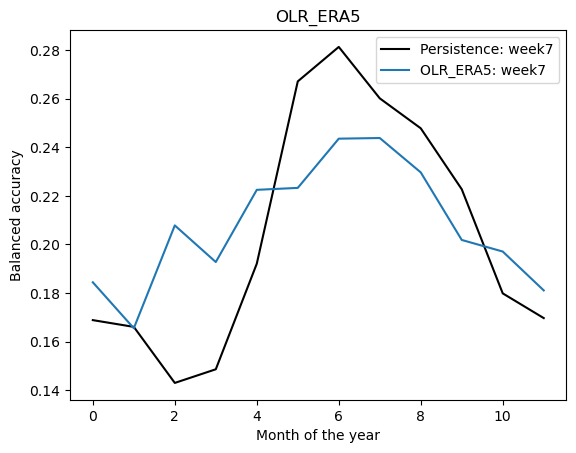

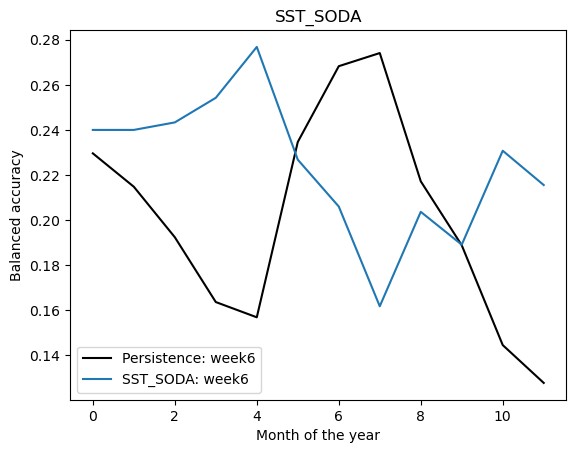

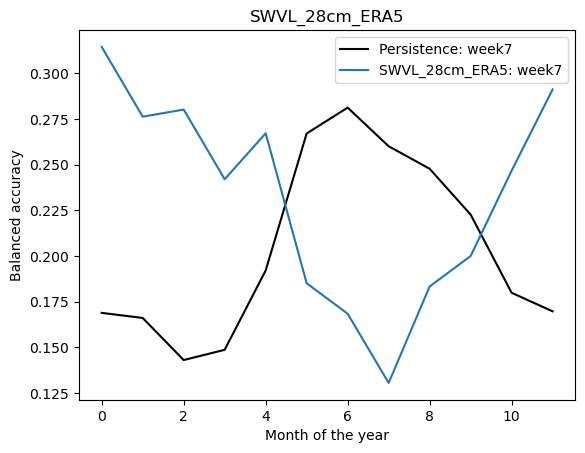

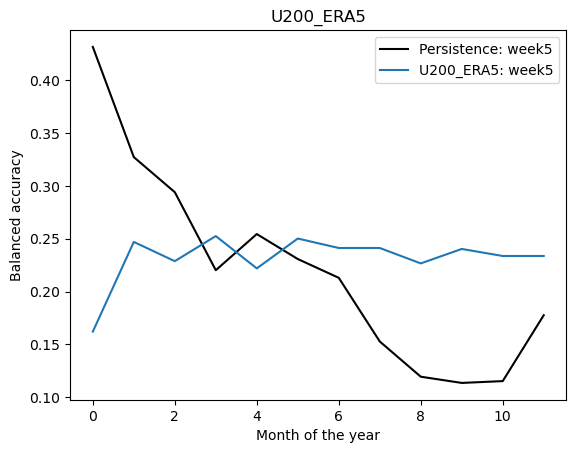

In [150]:
for name_var in ['IT_SODA', 'OHC100_SODA', 'SD_ERA5', 'STL_full_ERA5', 'SWVL_full_ERA5', 'Z500_ERA5',
                 'MLD_SODA', 'OLR_ERA5', 'SST_SODA', 'SWVL_28cm_ERA5', 'U200_ERA5']:
    week_out = (df_acc[name_var] - df_acc['Persistence']).argmax()
    week_out_str = f'week{week_out}'
    plt.plot(pd.Series(dic_full[name_var][week_out]['acc_months_persistence']).rolling(3,min_periods=1).mean(),
             label = f'Persistence: {week_out_str}',color='k')
    plt.plot(pd.Series(dic_full[name_var][week_out]['acc_months']).rolling(3,min_periods=1).mean(),
             label = f'{name_var}: {week_out_str}')
    plt.title(name_var)
    plt.ylabel('Balanced accuracy')
    plt.xlabel('Month of the year')
    plt.legend()
    plt.show()
    plt.close('all')

# Final WR variation of performance

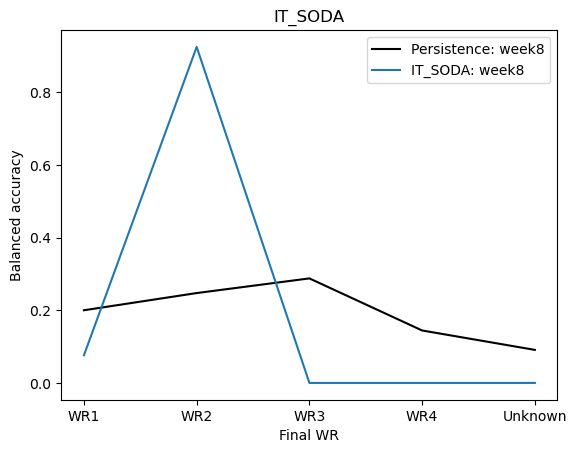

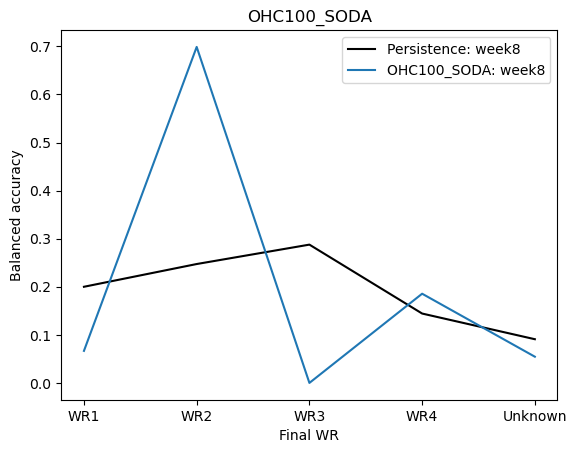

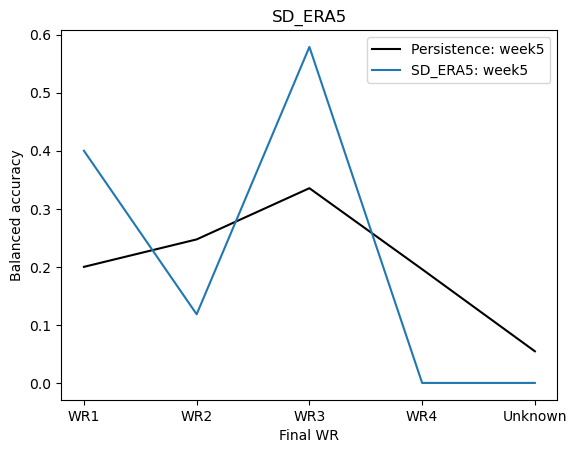

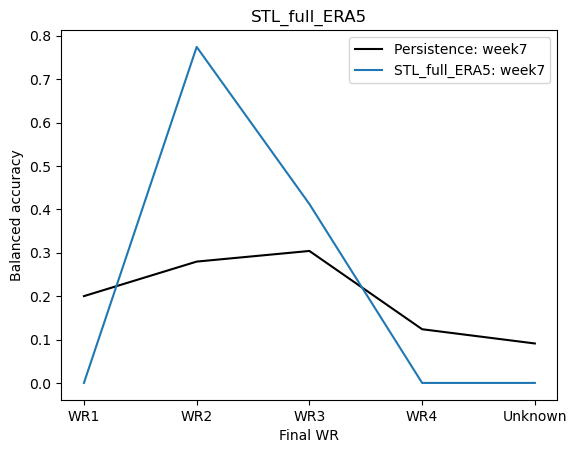

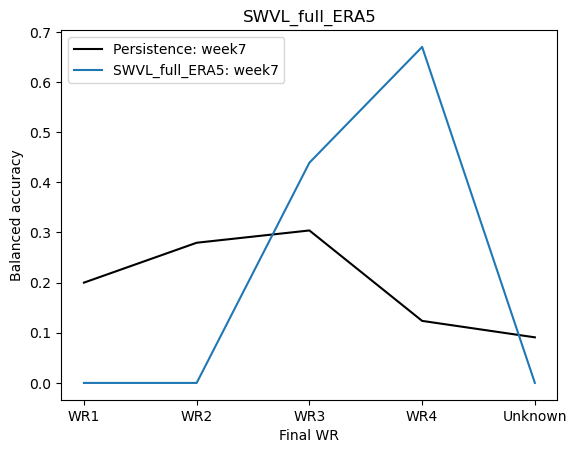

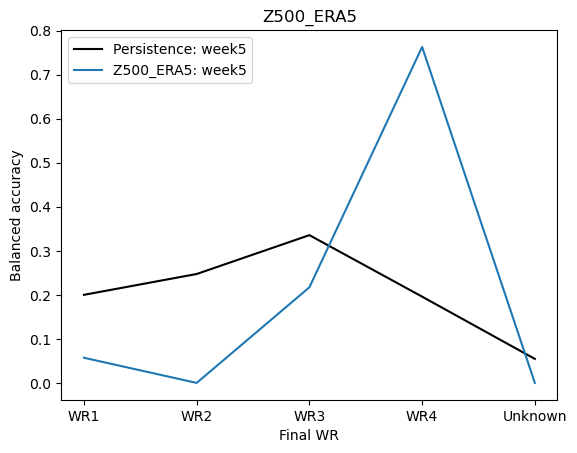

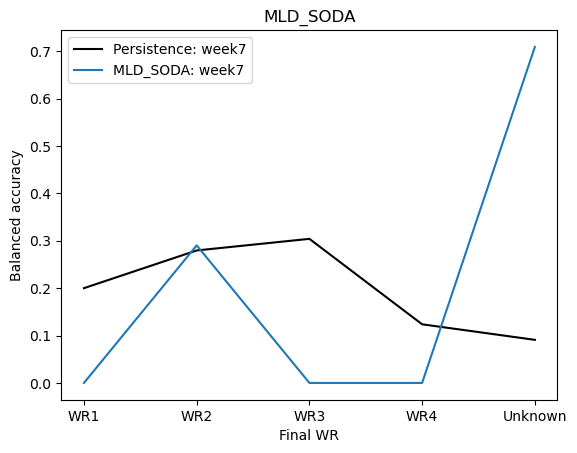

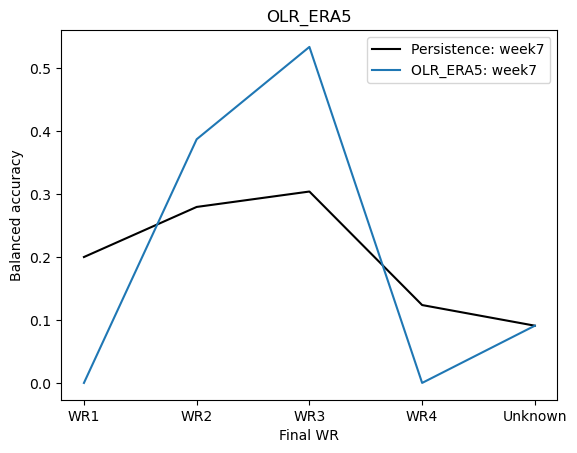

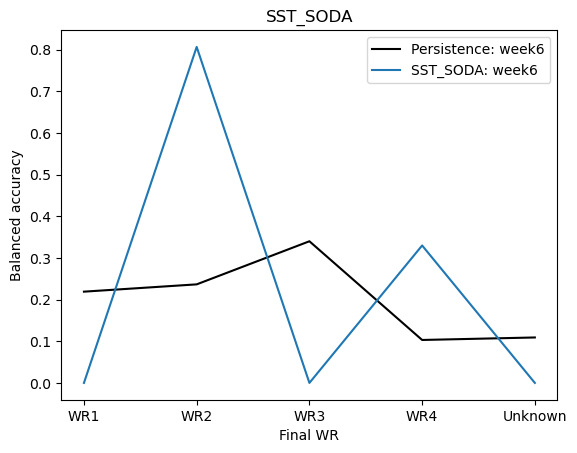

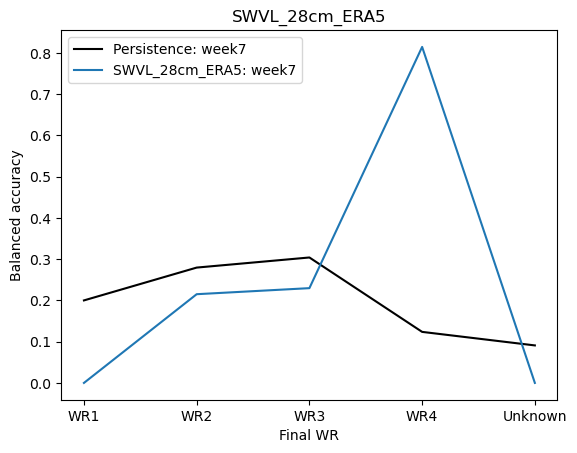

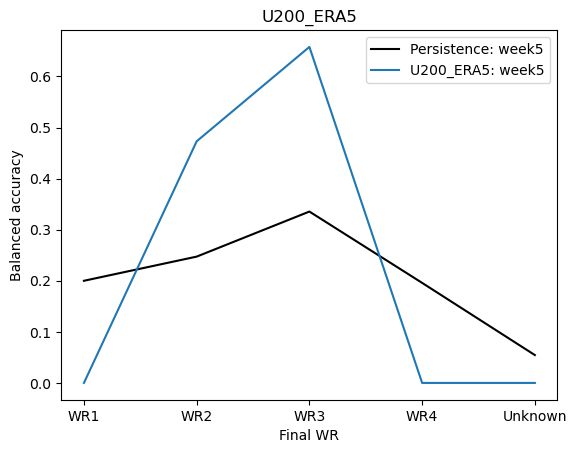

In [164]:
for name_var in ['IT_SODA', 'OHC100_SODA', 'SD_ERA5', 'STL_full_ERA5', 'SWVL_full_ERA5', 'Z500_ERA5',
                 'MLD_SODA', 'OLR_ERA5', 'SST_SODA', 'SWVL_28cm_ERA5', 'U200_ERA5']:
    week_out = (df_acc[name_var] - df_acc['Persistence']).argmax()
    week_out_str = f'week{week_out}'
    plt.plot([1,2,3,4,5],dic_full[name_var][week_out]['acc_final_wr_persistence'],
             label = f'Persistence: {week_out_str}',color='k')
    plt.plot([1,2,3,4,5],dic_full[name_var][week_out]['acc_final_wr'],
             label = f'{name_var}: {week_out_str}')
    plt.xticks([1,2,3,4,5],['WR1','WR2','WR3','WR4','Unknown'])
    plt.title(name_var)
    plt.ylabel('Balanced accuracy')
    plt.xlabel('Final WR')
    plt.legend()
    plt.show()
    plt.close('all')
    # aa

# Initial WR variation of performance

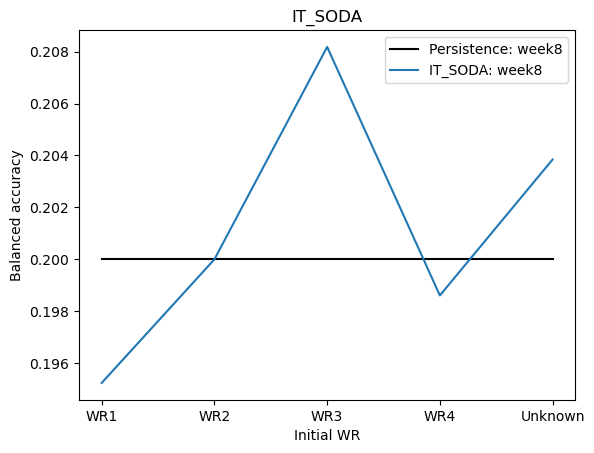

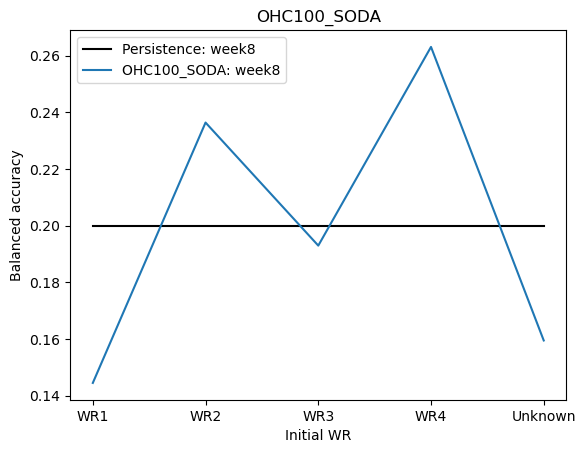

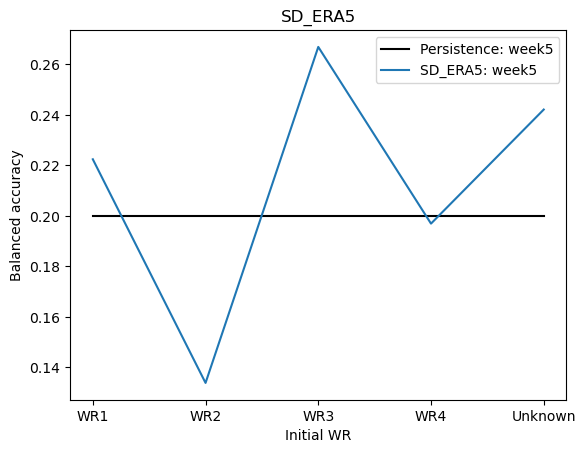

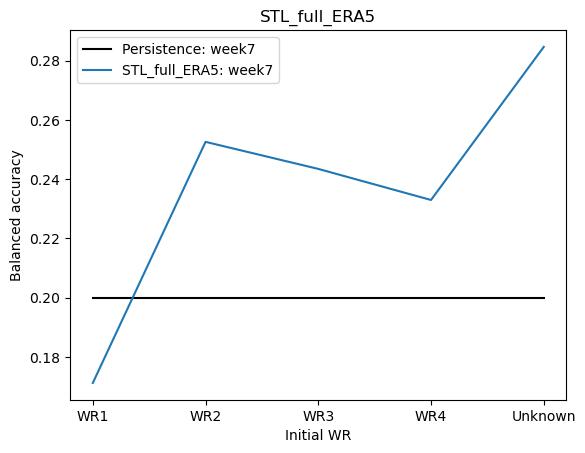

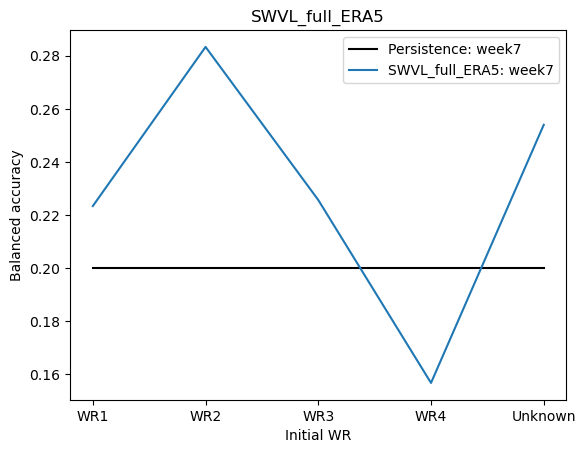

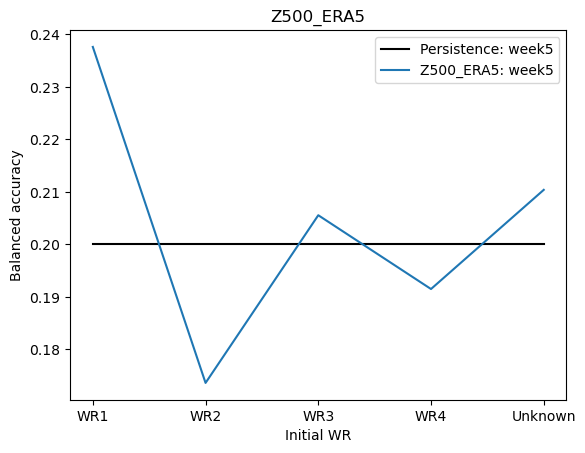

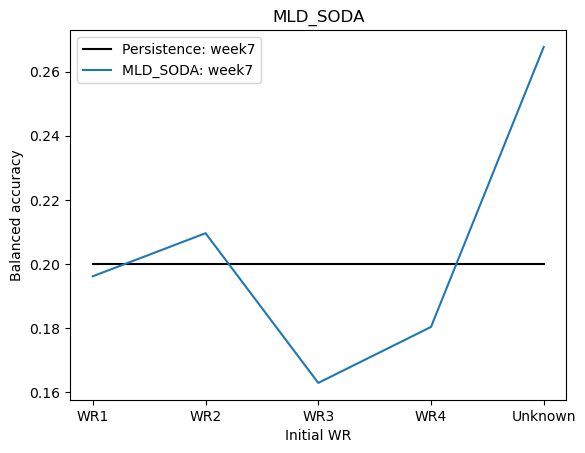

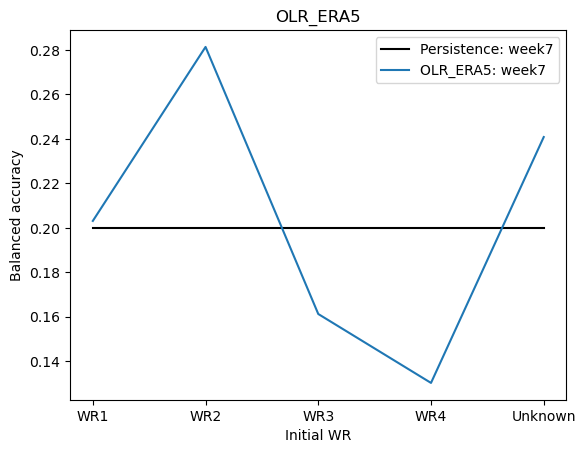

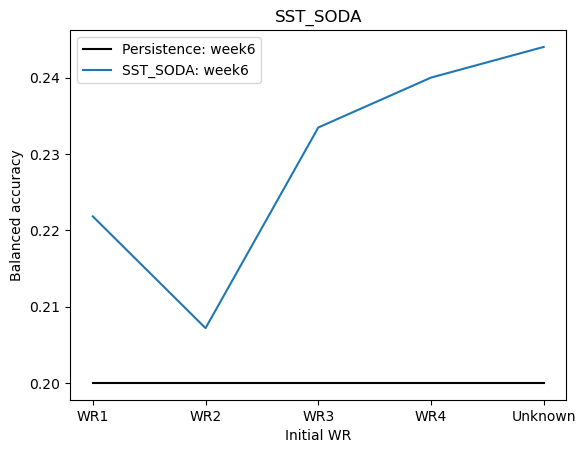

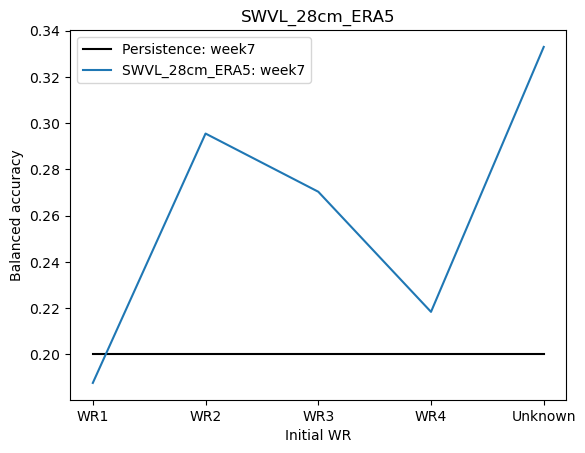

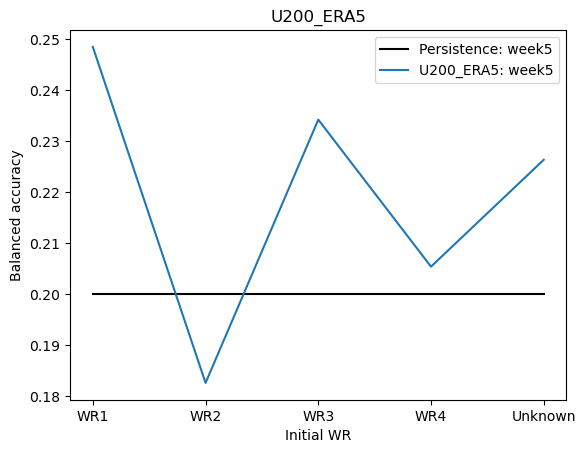

In [165]:
for name_var in ['IT_SODA', 'OHC100_SODA', 'SD_ERA5', 'STL_full_ERA5', 'SWVL_full_ERA5', 'Z500_ERA5',
                 'MLD_SODA', 'OLR_ERA5', 'SST_SODA', 'SWVL_28cm_ERA5', 'U200_ERA5']:
    week_out = (df_acc[name_var] - df_acc['Persistence']).argmax()
    week_out_str = f'week{week_out}'
    plt.plot([1,2,3,4,5],dic_full[name_var][week_out]['acc_init_wr_persistence'],
             label = f'Persistence: {week_out_str}',color='k')
    plt.plot([1,2,3,4,5],dic_full[name_var][week_out]['acc_init_wr'],
             label = f'{name_var}: {week_out_str}')
    plt.xticks([1,2,3,4,5],['WR1','WR2','WR3','WR4','Unknown'])
    plt.title(name_var)
    plt.ylabel('Balanced accuracy')
    plt.xlabel('Initial WR')
    plt.legend()
    plt.show()
    plt.close('all')
    # aa

In [156]:
dic_full[name_var][week_out]['acc_final_wr']

[0.0, 0.47368421052631576, 0.6103896103896104, 0.0, 0.0]